# Download Train and Test data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Dense_depth

/content/drive/My Drive/Dense_depth


In [ ]:
from pathlib import Path
print(Path.cwd())

/content/drive/My Drive/Dense_depth


In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu_data.zip
!unzip nyu_data.zip

In [ ]:
#!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip

# Set Paths

In [4]:
import os
DATA_PATH = '/content/drive/MyDrive/Dense_depth/'
SAVE_PATH = '/content/drive/MyDrive/Dense_depth'
#os.chdir(SAVE_PATH)
os.getcwd()

'/content/drive/My Drive/Dense_depth'

In [5]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

# Define Loss function

In [6]:
def depth_loss(y_true, y_pred, theta=0.1, maxDepthVal=1000.0/10.0):
    # Point-wise depth
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)

    # Edges
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)

    # Structural similarity (SSIM) index
    l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5, 0, 1)

    # Weights
    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

# Define Model

## Upscale block

In [7]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, LeakyReLU, Concatenate
from tensorflow.keras.applications import DenseNet169

class UpscaleBlock(Model):
    def __init__(self, filters):
        # call parent constructor
        super(UpscaleBlock, self).__init__()
        ALPHA = 0.2

        self.upscl = UpSampling2D(interpolation='bilinear')
        self.cncat = Concatenate()

        self.convA = Conv2D(filters, (3, 3) , padding='same')
        self.reluA = LeakyReLU(alpha=ALPHA)  

        self.convB = Conv2D(filters, (3, 3), padding='same')
        self.reluB = LeakyReLU(alpha=ALPHA)
    
    def call(self, inputs):
        x = self.upscl(inputs[0])
        x = self.cncat([x, inputs[1]])
        
        x = self.convA(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.reluB(x)

        return x

## Encode Block

In [8]:
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()

        self.base = DenseNet169(input_shape=(None, None, 3) ,include_top=False)

        outputs = [self.base.outputs[-1]]
        for name in ['pool1', 'pool2_pool', 'pool3_pool', 'conv1/relu']:
            outputs.append(self.base.get_layer(name).output)

        self.encoder = Model(inputs = self.base.inputs, outputs = outputs)       

    def call(self, inputs):
        x = self.encoder(inputs)
        return x

## Decode Block


In [9]:
class Decoder(Model):
    def __init__(self, filters):
        super(Decoder, self).__init__()

        self.convA = Conv2D(filters, (1, 1), padding='same')

        self.upA = UpscaleBlock(filters=filters//2)
        self.upB = UpscaleBlock(filters=filters//4)
        self.upC = UpscaleBlock(filters=filters//8)
        self.upD = UpscaleBlock(filters=filters//16)

        self.convB = Conv2D(1, (3, 3), padding='same')
    
    def call(self, inputs):
        x, pool1, pool2, pool3, conv1 = inputs[0], inputs[1], inputs[2], inputs[3], inputs[4]

        x = self.convA(x)
        x = self.upA([x, pool3])
        x = self.upB([x, pool2])
        x = self.upC([x, pool1])
        x = self.upD([x, conv1])
        x = self.convB(x)

        return x

## Combining Encoder and Decoder

In [11]:
class DenseDepth(Model):
    def __init__(self):
        super(DenseDepth, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder(filters=int(self.encoder.layers[-1].output[0].shape[-1] // 2))
    
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)

        return x


# Data Loader

In [12]:
import tensorflow as tf

from sklearn.utils import shuffle

class DataLoader():
    def __init__(self, csv_file='/content/drive/MyDrive/Dense_depth/data/nyu2_train.csv', DEBUG=False, NUMBER_DATA=None, split_ratio=5):
        self.shape_rgb = (480, 640, 3)
        self.shape_depth = (240, 320, 1)
        self.split_ratio = split_ratio
        self.read_data(csv_file, DEBUG=DEBUG, num_images=NUMBER_DATA)

    def nyu_resize(self, img, resolution=480, padding=6):
        from skimage.transform import resize
        return resize(img, (resolution, int(resolution*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True )

    def read_data(self, csv_file, DEBUG=False, num_images=None):
        csv = open(csv_file, 'r').read()
        datalist = list((row.split(',') for row in (csv).split('\n') if len(row) > 0))

        datalist = shuffle(datalist, random_state=10)

        if num_images is None:
            num_images = len(datalist)

        if DEBUG:
            num_images = 10
        
        split_pt = int(num_images * (self.split_ratio - 1) / self.split_ratio)
        train = datalist[0:split_pt]
        test = datalist[split_pt:num_images]

        self.train_filenames = [i[0] for i in train]
        self.train_labels = [i[1] for i in train]

        self.test_filenames = [i[0] for i in test]
        self.test_labels = [i[1] for i in test]

    def _parse_function(self, filename, label): 
        # Read images from disk
        image_decoded = tf.image.decode_jpeg(tf.io.read_file(filename))
        depth_resized = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(label)), [self.shape_depth[0], self.shape_depth[1]])

        # Format
        rgb = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
        depth = tf.image.convert_image_dtype(depth_resized / 255.0, dtype=tf.float32)
        
        # Normalize the depth values (in cm)
        depth = 1000 / tf.clip_by_value(depth * 1000, 10, 1000)

        return rgb, depth

    def get_batched_dataset(self, batch_size):
        train_data = tf.data.Dataset.from_tensor_slices((self.train_filenames, self.train_labels)) \
                        .shuffle(buffer_size=len(self.train_filenames), reshuffle_each_iteration=True) \
                        .repeat() \
                        .map(map_func=self._parse_function) \
                        .batch(batch_size=batch_size)

        test_data = tf.data.Dataset.from_tensor_slices((self.test_filenames, self.test_labels)) \
                        .map(map_func=self._parse_function) \
                        .batch(batch_size=batch_size)
                    
        return train_data, test_data

# Train

In [13]:
import math

batch_size = 4
learning_rate = 0.0001
c_split_ratio = 5

# Max total batches: 6336 at batch_size=8
## Keep train_batch_num higher to not let model overfit
train_batch_num = 5000

def get_num_images(train_batch_num):
    num_images = int((batch_size * train_batch_num) * (c_split_ratio / (c_split_ratio-1)))
    return num_images

num_images = get_num_images(train_batch_num)
print(num_images)
test_batch_num = math.ceil((num_images - train_batch_num * batch_size) * 1.0 / batch_size)
print(test_batch_num)

if test_batch_num + train_batch_num > 6300:
    print("TF Warning") 

25000
1250


In [14]:
dl = DataLoader(csv_file='/content/drive/MyDrive/Dense_depth/data/nyu2_train.csv', NUMBER_DATA=num_images)
train_generator, val_generator = dl.get_batched_dataset(batch_size)

In [15]:
os.chdir(DATA_PATH)
os.getcwd()

'/content/drive/MyDrive/Dense_depth'

In [ ]:


model = DenseDepth()
model.compile(loss=depth_loss, 
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate, amsgrad=True))

checkpoint_path = "/content/drive/MyDrive/Dense_depth/Training/DenseDepth.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                    checkpoint_path, save_weights_only=False, verbose=1,
                    save_best_only=True)

EPOCHS = 200
train_steps = 50
val_steps = 10

es_patience = EPOCHS//10
early_stop = tf.keras.callbacks.EarlyStopping(
                    patience=es_patience,
                    restore_best_weights=True)

history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=train_steps, 
                    validation_data=val_generator, validation_steps=val_steps, 
                    #validation_split=0.2,
                    shuffle=True, 
                    callbacks=[cp_callback], 
                    verbose=1)

Epoch 1/200
50/50 [==============================] - 47s 611ms/step - loss: 0.4468 - val_loss: 0.3028

Epoch 00001: val_loss improved from inf to 0.30282, saving model to /content/drive/MyDrive/Dense_depth/Training/DenseDepth.ckpt
Epoch 2/200
50/50 [==============================] - 28s 555ms/step - loss: 0.2534 - val_loss: 0.2498

Epoch 00002: val_loss improved from 0.30282 to 0.24980, saving model to /content/drive/MyDrive/Dense_depth/Training/DenseDepth.ckpt
Epoch 3/200
50/50 [==============================] - 28s 548ms/step - loss: 0.2353 - val_loss: 0.3031

Epoch 00003: val_loss did not improve from 0.24980
Epoch 4/200
50/50 [==============================] - 28s 553ms/step - loss: 0.2231 - val_loss: 0.1948

Epoch 00004: val_loss improved from 0.24980 to 0.19483, saving model to /content/drive/MyDrive/Dense_depth/Training/DenseDepth.ckpt
Epoch 5/200
50/50 [==============================] - 28s 553ms/step - loss: 0.2124 - val_loss: 0.2000

Epoch 00005: val_loss did not improve from

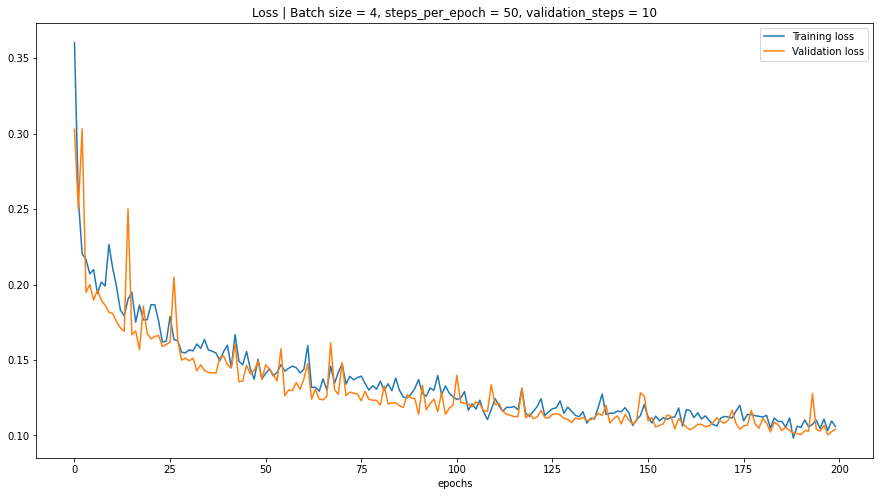

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 8))

plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Loss | Batch size = ' + str(batch_size) + ', steps_per_epoch = ' + str(train_steps) + ', validation_steps = ' + str(val_steps))
plt.xlabel('epochs')
os.chdir(SAVE_PATH)
plt.savefig('loss.png')

# Test Helper functions

## Utils

In [16]:
import cv2
import numpy as np

def DepthNorm(x, maxDepth):
    return maxDepth / x

def predict(model, images, minDepth=10, maxDepth=1000, batch_size=2):
    # Support multiple RGBs, one RGB image, even grayscale 
    if len(images.shape) < 3: images = np.stack((images,images,images), axis=2)
    if len(images.shape) < 4: images = images.reshape((1, images.shape[0], images.shape[1], images.shape[2]))
    # Compute predictions
    predictions = model.predict(images, batch_size=batch_size)
    # Put in expected range
    return np.clip(DepthNorm(predictions, maxDepth=maxDepth), minDepth, maxDepth) / maxDepth

# Test

In [17]:
os.chdir(SAVE_PATH)
print('Loading model...')
model = DenseDepth()
checkpoint_path = "Training/DenseDepth.ckpt"
model.load_weights(checkpoint_path)
print('Model weights loaded.')

Loading model...
51879936/51877672 [==============================] - 1s 0us/step
Model weights loaded.


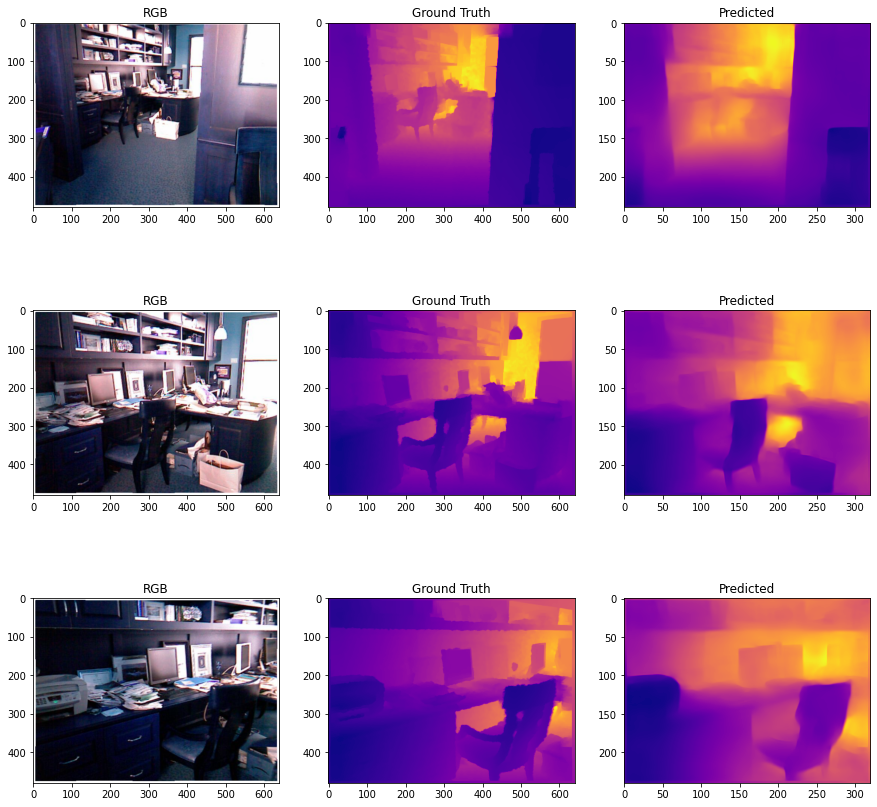

In [18]:
count = 3

os.chdir(SAVE_PATH)
path_pre = DATA_PATH + 'data/nyu2_test/'
files = [f for f in os.listdir(path_pre) if f.split('_')[1] == 'colors.png']
(fig, axes) = plt.subplots(nrows=count, ncols=3, figsize=(15,15))
i = 0
for f in files:
    file_id = f.split('_')[0]
    depth_file = file_id + '_depth.png'
    img = cv2.imread(path_pre + f, cv2.IMREAD_COLOR)
    axes[i][0].imshow(img)
    axes[i][0].set_title('RGB')

    img = np.clip(img/255, 0, 1)
    img = predict(model, img, batch_size=1)
    axes[i][2].imshow(img[0,:,:,0], cmap='plasma')
    axes[i][2].set_title('Predicted')

    img = cv2.imread(path_pre + depth_file, cv2.IMREAD_ANYDEPTH)
    axes[i][1].imshow(img, cmap='plasma')
    axes[i][1].set_title('Ground Truth')
    
    if i == count-1:
        break
    else:
        i += 1

plt.savefig('result.png')

# Evaluation

In [19]:
from evaluate import load_test_data, evaluate

rgb, depth, crop = load_test_data()
evaluate(model, rgb, depth, crop)

Loading test data...Test data loaded.

        a1,         a2,         a3,        rel,        rms,     log_10
    0.8012,     0.9625,     0.9924,     0.1405,     0.5261,     0.0617
